# Lab 04 : Numerical Integration

## Objectives

In this lab we will study the extremely powerful integration routine provided for us in `scipy.integrate.quad`.  Despite being extremely powerful, we can make it even better by performing mathematical transformations of the integrals we wish to evaluate.   **This lab is an extension of the analytic work performed in Homework 04, Problem 1 and relies on some of those results.**

We will study the simple pendulum.  Despite being "simple", recall from introductory physics that we can only solve for the motion of small amplitude oscillations.   Here we will study the full motion of the pendulum.

## Initialization

You can mostly just run the following and ignore the details.  This is some magic required to get equation numbering and referencing working (another of the many great features of $\LaTeX$).  **You need to run this cell to get equations numbered and labels to work.**  You also need to rerun this cell anytime you need to rerender the numbered equations found below.  It shows how other languages can be included in a Jupyter notebook.  In this case it is javascript, but C, FORTRAN, and many other languages could be included in a similar manner.

In [1]:
%%javascript
// Turn on automatic equations numbers and allow for equation labeling and referencing.
MathJax.Hub.Config({
  TeX: { equationNumbers: { autoNumber: "AMS" } }
});
// The following reprocesses/renumbers the equations when executed.  When cells with numbered equations are reprocessed
// the equation number keeps incrementing.  When numbered equations have labels an error occurs and the equation does not
// actually get rendered.  Rerun this cell to reset the equation numbers and render all the equations in the document.
MathJax.Hub.Queue(
    ["resetEquationNumbers",MathJax.InputJax.TeX],
    ["PreProcess",MathJax.Hub], 
    ["Reprocess",MathJax.Hub]
);

<IPython.core.display.Javascript object>

As always initialize, your environment now by loading all modules required and setting up the plotting environment. 

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.integrate as integ
# Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

## Pendulum Motion

As seen in the homework, the period of the oscillations of a pendulum can be written in a few equivalent forms: 
\begin{align}
\frac{T(\theta_m)}{T_0} & = \frac{\sqrt 2}{\pi} \int_0^{\theta_m} \frac{\mathrm{d}\theta}{\sqrt{\cos\theta-\cos\theta_m}}, \label{eq:period1} \\
 & = \frac{2}{\pi} \int_0^{\pi/2} \frac{\mathrm{d}\psi}{\sqrt{1-\sin^2(\theta_m/2)\sin^2\psi}}, \label{eq:period2} \\
 & = 1 + \sum_{n=1}^\infty a_{2n} \sin^{2n}(\theta_m/2). \label{eq:periodsum}
\end{align}
For the series form, you have calculated the values of the coefficients up to $a_8$.  We will explore all of these forms in this lab.

### Period Calculations

Calculate the period using the three expressions above for $\theta_m$ on a grid from 1 to 179 degrees in steps of 1 degree.  For the two integrals $(\ref{eq:period1})$ and $(\ref{eq:period2})$ we cannot avoid writing a loop since `quad` cannot compute many integrals at once.  (In the future we will learn that there is a way to get NumPy to create the loop for us so that we do not need to explicitly write it ourselves.)  For the series $(\ref{eq:periodsum})$ we *could* avoid writing a loop, but we have not learned how and since we already need to write one loop we may as well use it for this case also.  As seen in the example this week, when we do need to write our own loops it is best to preallocate storage space for the results using `np.zeros` or `np.zeros_like`.

Also produce a figure showing the period calculated from the three methods as a function of the pendulum amplitude.

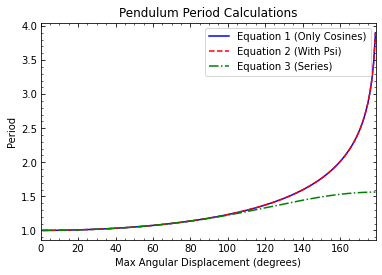

In [7]:
def eqn1(t, t_m):
    """The fuction to evaulate equation 1
    
    Parameters
    ----------
    t : number
        Value at which to evaluate the function (in radians).
    t_m: number
        Max angular displacement (in radians).
    """

    return (np.sqrt(2) /np.pi) * (1 / np.sqrt(np.cos(t) - np.cos(t_m)))
                           
def eqn2(p, t_m):
    """The fuction to evaulate equation 2
    
    Parameters
    ----------
    p : number
        Value at which to evaluate the function (in radians).
    t_m: number
        Max angular displacement (in radians).
    """
    return (2) / (np.pi * np.sqrt(1 - np.sin(t_m / 2)**2 * np.sin(p)**2))

def eqn3(t_m):
    """The fuction to evaulate equation 3
    
    Parameters
    ----------
    t_m: number
        Max angular displacement (in radians).
    """
    #t_m = np.radians(t_m)
    a2 = (1/4)*np.sin(t_m/2)**2
    a4 = (9/64)*np.sin(t_m/2)**4
    a6 = (25/256)*np.sin(t_m/2)**6
    a8 = (1225/16384)*np.sin(t_m/2)**8
    return (1 + a2 + a4 + a6 + a8)

xValues_d = np.arange(1., 180., 1) # our theta values in degrees
xValues = np.radians(xValues_d) # our theta values converted to radians 
y1 = np.zeros_like(xValues) # preallocated storage space the same size as our x values
y2 = np.zeros_like(xValues)
y3 = np.zeros_like(xValues)

for i in range (len(xValues)):
    y1[i] = integ.quad(eqn1, 0, xValues[i], args = xValues[i])[0]
    y2[i] = integ.quad(eqn2, 0, np.pi/2 , args = xValues[i])[0]
    y3[i] = eqn3(xValues[i])


plt.plot(xValues_d, y1,'b-', label="Equation 1 (Only Cosines)")
plt.plot(xValues_d, y2,'r--', label="Equation 2 (With Psi)")
plt.plot(xValues_d, y3,'g-.', label="Equation 3 (Series)")
plt.title("Pendulum Period Calculations")
plt.xlabel("Max Angular Displacement (degrees)")
plt.ylabel("Period")
plt.xlim([0,179])
plt.legend()
plt.show()

### Error in the Integrals

You should find that the two integrals agree with each other, but that the series does not agree with the intrals for large amplitudes.  We will look at the series in more detail below.  For now let us focus on the integrals; we want to carefully look at their accuracy.  As noted in the homework, the integral *can* actually be performed in terms of a special function, the elliptic integral of the first kind,
$$ \frac{T(\theta_m)}{T_0} = \frac{2}{\pi} K\left[ \sin^2\left( \frac{\theta_m}{2} \right) \right]. $$
The elliptic integral of the first kind can be accessed as `scipy.special.ellipk`. (*Note:* I have used a notation here consistent with SciPy, however, this is not universal.  In other places you will find what we are calling $K(x^2)$ instead written as $K(x)$.  In general, before using a special function you should verify the library is using the same conventions as you are!)

We are going to produce another figure. Whenever multiple figures are produced using the same quantities, in every figure you should always use the same line style or marker type, colors, *etc*. for the same quantity in each figure.  This makes it much easier for the reader to connect the results among the figures.  For example, this means that if you used purple horse shoes to represent the integral from Eq. $(\ref{eq:period1})$ in your first figure, then you should also use purple horse shoes to represent the error in the integral from Eq. $(\ref{eq:period1})$ in the figure you are about to create. (*Note:*  Do **not** use purple horse shoes as a marker.)

Produce a figure showing the fractional error in the two integrals $(\ref{eq:period1})$ and $(\ref{eq:period2})$.  You may get a warning when you create this plot and/or one of the curves may look strange.

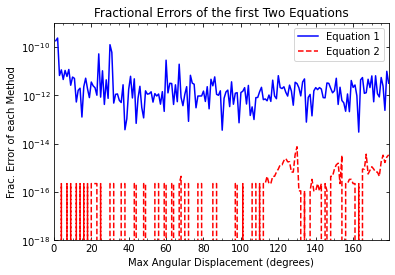

In [129]:
true_val = (2/np.pi) * scipy.special.ellipk(np.sin(xValues/2)**2)
plt.semilogy(xValues_d, np.abs(1 - y1/true_val), 'b-', label = "Equation 1")
plt.semilogy(xValues_d, np.abs(1 - y2/true_val), 'r--', label = "Equation 2")
plt.title("Fractional Errors of the first Two Equations")
plt.xlabel("Max Angular Displacement (degrees)")
plt.ylabel("Frac. Error of each Method")
plt.xlim([0,179])
plt.ylim(1e-18,1e-9)
plt.legend()
plt.show()
#print(np.abs(1 - y2/true_val))

The error from the integral in Eq. $(\ref{eq:period2})$ should look strange.  You may be worried that is incorrect.  Explain the source of the strange behavior of this error curve.  (*Hint:* Look at the actual values of the errors, not just as they show up in the plot.)

As we comb through the actual error values we see a number of indices with magnitude zero. This means that equation 2 calculated certain values of angular displacements that were the exact same as the "true value" special elliptic integral of the first kind (at least to within machine precision). The method in which eq 2. and the special elliptic integral make their calcualtions must be rather similiar, meaning that eq 2. is incredibly accurate compared to the special elliptic integral value. Even the largest of errors from eq 2. are no more larger than $10^{-15}$!

### Series Formula

Returning to the series form in $(\ref{eq:periodsum})$ it is not surprising that it does a poor job at large amplitude, particularly since we truncate the sum after a few terms, at $a_8$.  Explain why this is the case.

Our sum is centered about $\theta=0$; therefore, values relatively close to $\theta=0$ should have good accuracy. We also explicitly put in terms up to $a_{8}$, and truncated values thereafter. The explicitly calculated terms should have relatively high accuracy. We see that in our Pendulum Period Calculation graph, that this accuracy is good until theta reaches ~110 degrees. As our expansion goes to higher, truncated terms, we are bound to see a decrease in accuracy as the model relies on truncated values. 

For what amplitude, $\theta_m$, from the grid used above, does the fractional error in the period calculated using the series form $(\ref{eq:periodsum})$ become larger than $10^{-10}$?  (*Note:* The clever way to do this is to use the `where` function, though we have not discussed the `where` function yet so is not necessary to use it here here. Instead, you can just look through the list of values and find the relevant one.  We will learn about the `where` function in the near future.  Also note that we want the **value of the amplitude, $\theta_m$**, not the index number of where this occurs in the array you calculated.)

In [130]:
idx = np.abs(1 - y3/true_val) > 1e-10 #index of where the fracitonal error is large than 10^-10 [16]
y3[15]
print(f"""The corresponding amplitude, theta max, for which the fractional error of the period calculated from eq.3 becomes larger than 10^-10
is {y3[15]:.3f} and this corresponds to an actual theta value of {xValues_d[15]} degrees!

""")

The corresponding amplitude, theta max, for which the fractional error of the period calculated from eq.3 becomes larger than 10^-10
is 1.005 and this corresponds to an actual theta value of 16.0 degrees!




## Analytic Manipulations

You may wonder why we bothered to have two different integral forms for the period, $(\ref{eq:period1})$ and $(\ref{eq:period2})$.  Since `quad` can handle divergent integrands it can, and does, give us good answers to the integral in Eq. $(\ref{eq:period1})$, so why bother doing the analytic work to transform the integral?  We found above that the transformed integral $(\ref{eq:period2})$ did lead to smaller errors, so that is a benefit.  Even more so, the transformed integral requires far less work to compute.  Thus by doing a small mathematical manipulation (as you have done in the homework) we arrive at a much easier and much more accurate formula for the computer to evaluate.

To verify this, calculate the period for $\theta_m=97^\circ$ using $(\ref{eq:period1})$ and $(\ref{eq:period2})$.  Print the fractional errors and number of function evaluations required for each integral.  Be amazed!

In [139]:
def eqn1(t):
    return (np.sqrt(2) /np.pi) * (1 / np.sqrt(np.cos(t) - np.cos(np.radians(97))))
                           
def eqn2(p):
    return (2) / (np.pi * np.sqrt(1 - np.sin(np.radians(97) / 2)**2 * np.sin(p)**2))

    
(int1,dummy1,info1) = integ.quad(eqn1,0,np.radians(97), full_output=1)
(int2, dummy2, info2) = integ.quad(eqn2,0,np.pi/2, full_output=1)
elliptic_int=(2/np.pi) * scipy.special.ellipk(np.sin(np.radians(97)/2)**2)

#dummy variables are the estimated error in the integral. They are not of much importance to us

frac_err1 = np.abs(1 - int1/elliptic_int)
frac_err2 = np.abs(1-int2/elliptic_int)

#info1['neval']
#info2['neval']
dummy1

print(f"""
The fractional error using eq. 1 is {frac_err1:.2e} and it took {info1['neval']} function evaluations to find the value at theta = 97 degrees.

The fractional error using eq. 2 is {frac_err2:.2e} which is remarkably lower! And it only took {info2['neval']} function evaluations to reach a value!

We must say, we are quite amazed at how a small mathemaical manipulation can make for a much more accurate numerical result in a fraction of the time.

""")


The fractional error using eq. 1 is 1.22e-12 and it took 315 function evaluations to find the value at theta = 97 degrees.

The fractional error using eq. 2 is 2.22e-16 which is remarkably lower! And it only took 21 function evaluations to reach a value!

We must say, we are quite amazed at how a small mathemaical manipulation can make for a much more accurate numerical result in a fraction of the time.




## Member Participation

See Lab00 for instructions on turning in labs.  We will follow this procedure the entire semester.

In the following cell enter the *Case ID* for each student in the group who partcipated in this lab.  Again, see Lab00 for more details.  It is expected that you have read and understood those details.

crk97, zlt5